## Calculate "missing genes" for all experiments

We observed that as we added more data types, we're ending up with fewer genes in our cross-validation experiments. The reasons for this are described in more detail in https://github.com/greenelab/mpmp/issues/44, but basic reasons include:

* No valid cancer types that meet our filters (this is more likely with more data types -> fewer samples)
* In one or more cross-validation splits, either the train or test set has no positive or negative samples (i.e. only one class -> AUROC/AUPR are not defined)

In this script, we want to calculate the number of missing genes without having to fit every model (this will run on the order of ~1 hour, rather than a day or two with the model fits).

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

from mpmp.data_models.tcga_data_model import TCGADataModel
import mpmp.prediction.cross_validation as cv
import mpmp.utilities.data_utilities as du

In [2]:
def calculate_gene_count(overlap_data_types, seeds, num_folds):
    """For a set of data types, calculate the number of valid genes."""
    gene_seed_list = []
    sample_info_df = du.load_sample_info('expression')
    for seed in seeds:
        tcga_data = TCGADataModel(seed=seed,
                                  overlap_data_types=overlap_data_types)
        genes_df = tcga_data.load_gene_set('vogelstein')
        for gene_ix, gene_series in genes_df.iterrows():
            
            print(gene_series.gene, file=sys.stderr)
            try:
                tcga_data.process_data_for_gene(gene_series.gene,
                                                gene_series.classification,
                                                None)
            except KeyError: continue
            y_ones = np.count_nonzero(tcga_data.y_df.status)
            y_zeroes = len(tcga_data.y_df.status) - y_ones
            print(y_ones, y_zeroes, file=sys.stderr)
            
            # check if any valid cancer types, if not break
            if tcga_data.X_df.shape[0] == 0:
                gene_seed_list.append((gene_series.gene, seed, False, 'no_valid_cancer_types'))
                continue
                
            # subset features to speed up CV
            tcga_data.X_df = tcga_data.X_df.iloc[:, :50]
                
            # if valid cancer types, look at CV folds and make sure each
            # has 0 and 1 labels
            gene_seed_valid = True
            reason = 'N/A'
            for fold_no in range(num_folds):
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore',
                                            message='The least populated class in y')
                    X_train, X_test, _ = cv.split_stratified(
                        tcga_data.X_df,
                        sample_info_df,
                        num_folds=num_folds,
                        fold_no=fold_no,
                        seed=seed
                    )
                y_train = tcga_data.y_df.reindex(X_train.index)
                y_test = tcga_data.y_df.reindex(X_test.index)
                
                # count 0/1 labels in y_train and y_test
                y_train_ones = np.count_nonzero(y_train.status)
                y_train_zeroes = len(y_train.status) - y_train_ones
                y_test_ones = np.count_nonzero(y_test.status)
                y_test_zeroes = len(y_test.status) - y_test_ones
                print(fold_no, y_train_ones, y_train_zeroes, y_test_ones, y_test_zeroes,
                      file=sys.stderr)
                
                if ((y_train_ones == 0) or (y_train_zeroes == 0)):
                    gene_seed_valid = False
                    reason = 'one_train_class'
                    break
                elif ((y_test_ones == 0) or (y_test_zeroes == 0)):
                    gene_seed_valid = False
                    reason = 'one_test_class'
                    break
                    
            gene_seed_list.append((gene_series.gene, seed, gene_seed_valid, reason))
                
    return gene_seed_list

In [3]:
training_data_types = {
    'expression': ['expression'],
    'methylation': ['expression', 'me_27k', 'me_450k'],
    'all': ['expression', 'me_27k', 'me_450k', 'rppa', 'mirna', 'mut_sigs']
}
seeds = [42, 1]
num_folds = 4

gene_counts_dir = Path('./', 'gene_counts')
gene_counts_dir.mkdir(exist_ok=True)

# run for all the data types ("experiments") we want to consider
# if results already exist we don't have to recalculate them
for dataset, overlap_data_types in training_data_types.items():
    gene_count_file = gene_counts_dir / 'gene_count_{}.tsv'.format(dataset)
    if gene_count_file.is_file():
        print('File {} exists'.format(gene_count_file), file=sys.stderr)
    else:
        print('File {} does not exist, calculating'.format(
            gene_count_file), file=sys.stderr)
        lst = calculate_gene_count(overlap_data_types, seeds, num_folds)
        with open (gene_count_file, 'w') as f:
            for t in lst:
                f.write('\t'.join([str(v) for v in t]))
                f.write('\n')

File gene_counts/gene_count_expression.tsv exists
File gene_counts/gene_count_methylation.tsv exists
File gene_counts/gene_count_all.tsv exists


In [4]:
# now load gene count files and count valid genes
valid_genes_datasets = {}
for dataset in training_data_types.keys():
    gene_counts_df = pd.read_csv(
        gene_counts_dir / 'gene_count_{}.tsv'.format(dataset),
        names=['gene', 'seed', 'is_valid', 'reason'], 
        sep='\t'
    )
    valid_genes = gene_counts_df.groupby('gene').all().is_valid
    valid_genes_datasets[dataset] = valid_genes
    print('{}:'.format(dataset),
          '{} valid /'.format(np.count_nonzero(valid_genes)),
          '{} total'.format(len(valid_genes)))

expression: 85 valid / 124 total
methylation: 84 valid / 124 total
all: 75 valid / 124 total


### Compare valid genes to previously profiled gene set

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [6]:
dataset_directory = {
    'expression': 'vogelstein_expression_only',
    'methylation': 'compressed_results',
    'all': 'all_data_types_results'
}
dataset = 'expression'

# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   dataset_directory[dataset],
                   'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')
results_df = results_df[results_df.training_data == 'expression']

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(4920, 9)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.99386,0.93793,MAP3K1,expression,signal,42,train,0,gene
1,0.74244,0.34514,MAP3K1,expression,signal,42,test,0,gene
2,0.65156,0.20172,MAP3K1,expression,signal,42,cv,0,gene
3,0.99603,0.92337,MAP3K1,expression,signal,42,train,1,gene
4,0.66892,0.31002,MAP3K1,expression,signal,42,test,1,gene


In [7]:
all_results_df = au.compare_results(results_df,
                                    identifier='identifier',
                                    metric='aupr',
                                    correction=True,
                                    correction_method='fdr_bh',
                                    correction_alpha=SIG_ALPHA,
                                    verbose=True)
all_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
all_results_df.sort_values(by='p_value').head(10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH2, skipping
shapes unequal for PAX5, skipping
shapes unequal for PTPN11, skipping
shapes unequal for RUNX1, skipping


,gene,delta_mean,p_value,corr_pval,reject_null
94,TP53,0.407729,5.638959e-20,5.494995e-18,True
16,BRAF,0.617245,1.121428e-19,5.494995e-18,True
26,CTNNB1,0.593111,3.305822e-18,9.862705e-17,True
29,EGFR,0.584966,4.025594e-18,9.862705e-17,True
73,PIK3CA,0.335805,1.217084e-16,2.307799e-15,True
6,ARID1A,0.424040,1.412938e-16,2.307799e-15,True
58,KRAS,0.476266,6.849971e-16,9.589959e-15,True
4,APC,0.582659,8.595405e-16,1.052937e-14,True
23,CIC,0.545687,7.647812e-15,8.327617e-14,True
31,ERBB2,0.571202,1.846692e-14,1.809758e-13,True


In [8]:
prev_genes = all_results_df.gene.unique()
cur_genes = valid_genes_datasets[dataset][
    valid_genes_datasets[dataset] == True
].index.values
prev_not_cur = [g for g in prev_genes if g not in cur_genes]
cur_not_prev = [g for g in cur_genes if g not in prev_genes]
print(prev_not_cur)
print(cur_not_prev)

['ABL1', 'ACVR1B', 'AR', 'B2M', 'BRCA1', 'DNMT3A', 'HNF1A', 'MSH6', 'PTCH1', 'RET', 'SMO', 'TET2', 'TSHR']
[]


<AxesSubplot:title={'center':'Mutation prediction, Vogelstein et al., expression'}, xlabel='AUPR(signal) - AUPR(shuffled)', ylabel='$-\\log_{10}($adjusted $p$-value$)$'>

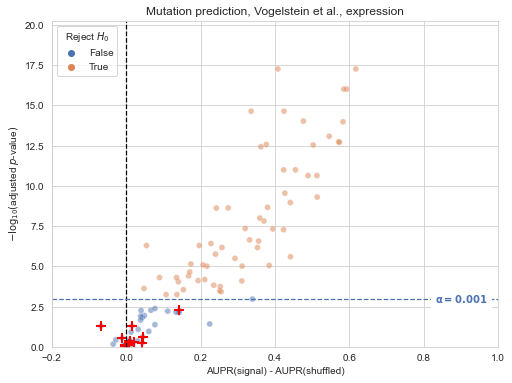

In [9]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA / 1000):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
ax = plt.gca()
sns.scatterplot(data=all_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=ax, alpha=0.5)
# add vertical line at 0
ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
# add horizontal line at statistical significance threshold
l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
# label horizontal line with significance threshold
# (matplotlib makes this fairly difficult, sadly)
ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
        r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
        va='center', ha='center', color=l.get_color(),
        backgroundcolor=ax.get_facecolor())
ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(title=r'Reject $H_0$', loc='upper left')
ax.set_title(r'Mutation prediction, Vogelstein et al., {}'.format(dataset))

prev_genes_df = all_results_df[all_results_df.gene.isin(prev_not_cur)]
sns.scatterplot(data=prev_genes_df, x='delta_mean', y='nlog10_p', ax=ax,
                marker='+', s=100, linewidth=2, color='red', legend=False)